In [3]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader
from dataset import DiscGradingDataset
from model import DiscGraderResNet
from loss import DiceLoss
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random
import matplotlib.pyplot as plt

In [4]:
roi_dir = "results/rois"

all_cases = []

for fname in sorted(os.listdir(roi_dir)):
    if not fname.endswith(".npz"):
        continue

    file_name = fname.replace(".npz", "")
    data = np.load(os.path.join(roi_dir, fname))

    all_cases.append(
        {"file_name": file_name, "rois": data["rois"]}  # shape (10, 128, 128)
    )

print("Loaded cases:", len(all_cases))
print("Example shape:", all_cases[0]["rois"].shape)

Loaded cases: 49
Example shape: (10, 128, 128)


In [5]:
grade_train_cases, grade_val_cases = train_test_split(
    all_cases, test_size=0.3, random_state=42
)

In [6]:
print(len(grade_val_cases))
print(len(grade_train_cases))

15
34


In [7]:
train_ds = DiscGradingDataset(grade_train_cases, "spider/radiological_gradings.csv")
val_ds = DiscGradingDataset(grade_val_cases, "spider/radiological_gradings.csv")

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

[GradingDataset] Total disc samples: 255
[GradingDataset] Total disc samples: 108


In [8]:
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)

In [9]:
model = DiscGraderResNet(n_classes=5, pretrained=True).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/Users/muradyan.e/wut/aidproject/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/muradyan.e/wut/aidproject/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
state_dict = torch.load('disc_grader_resnet18.pth', map_location=device)
model.load_state_dict(state_dict)
model.to(device)
model.eval()


DiscGraderResNet(
  (backbone): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [ ]:
EPOCHS = 20

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]")
    for x, y in pbar:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)
        preds = out.argmax(dim=1)
        train_correct += (preds == y).sum().item()
        train_total += y.size(0)

        pbar.set_postfix(
            {"loss": f"{loss.item():.4f}", "acc": f"{train_correct / train_total:.3f}"}
        )

    train_loss /= train_total
    train_acc = train_correct / train_total

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]")
        for x, y in pbar:
            x = x.to(device)
            y = y.to(device)

            out = model(x)
            loss = criterion(out, y)

            val_loss += loss.item() * x.size(0)
            preds = out.argmax(dim=1)
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

            pbar.set_postfix(
                {"loss": f"{loss.item():.4f}", "acc": f"{val_correct / val_total:.3f}"}
            )

    val_loss /= val_total
    val_acc = val_correct / val_total
    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.3f} | "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.3f}"
    )

Epoch 1/20 [Val]: 100%|██████████| 4/4 [00:00<00:00, 24.43it/s, loss=1.5644, acc=0.222]


Epoch 1/20 | Train Loss: 1.6344, Train Acc: 0.212 | Val Loss: 1.6053, Val Acc: 0.222


Epoch 2/20 [Val]: 100%|██████████| 4/4 [00:00<00:00, 80.75it/s, loss=1.5269, acc=0.250]


Epoch 2/20 | Train Loss: 1.4368, Train Acc: 0.376 | Val Loss: 1.5955, Val Acc: 0.250


Epoch 3/20 [Val]: 100%|██████████| 4/4 [00:00<00:00, 81.53it/s, loss=1.5445, acc=0.269]


Epoch 3/20 | Train Loss: 1.2477, Train Acc: 0.612 | Val Loss: 1.5881, Val Acc: 0.269


Epoch 4/20 [Val]: 100%|██████████| 4/4 [00:00<00:00, 82.36it/s, loss=1.5281, acc=0.231]


Epoch 4/20 | Train Loss: 1.1047, Train Acc: 0.651 | Val Loss: 1.5565, Val Acc: 0.231


Epoch 5/20 [Val]: 100%|██████████| 4/4 [00:00<00:00, 81.84it/s, loss=1.5124, acc=0.250]


Epoch 5/20 | Train Loss: 1.0146, Train Acc: 0.694 | Val Loss: 1.5831, Val Acc: 0.250


Epoch 6/20 [Val]: 100%|██████████| 4/4 [00:00<00:00, 81.64it/s, loss=1.4395, acc=0.250]


Epoch 6/20 | Train Loss: 0.8681, Train Acc: 0.792 | Val Loss: 1.5963, Val Acc: 0.250


Epoch 7/20 [Val]: 100%|██████████| 4/4 [00:00<00:00, 81.73it/s, loss=1.3820, acc=0.278]


Epoch 7/20 | Train Loss: 0.7355, Train Acc: 0.816 | Val Loss: 1.5551, Val Acc: 0.278


Epoch 8/20 [Val]: 100%|██████████| 4/4 [00:00<00:00, 82.29it/s, loss=1.4275, acc=0.278]


Epoch 8/20 | Train Loss: 0.6514, Train Acc: 0.875 | Val Loss: 1.5625, Val Acc: 0.278


Epoch 9/20 [Val]: 100%|██████████| 4/4 [00:00<00:00, 81.86it/s, loss=1.3837, acc=0.296]


Epoch 9/20 | Train Loss: 0.5732, Train Acc: 0.886 | Val Loss: 1.5468, Val Acc: 0.296


Epoch 10/20 [Val]: 100%|██████████| 4/4 [00:00<00:00, 77.94it/s, loss=1.3381, acc=0.278]


Epoch 10/20 | Train Loss: 0.4820, Train Acc: 0.902 | Val Loss: 1.5549, Val Acc: 0.278


Epoch 11/20 [Val]: 100%|██████████| 4/4 [00:00<00:00, 76.88it/s, loss=1.3706, acc=0.306]


Epoch 11/20 | Train Loss: 0.4157, Train Acc: 0.922 | Val Loss: 1.6038, Val Acc: 0.306


Epoch 12/20 [Val]: 100%|██████████| 4/4 [00:00<00:00, 76.16it/s, loss=1.3406, acc=0.269]


Epoch 12/20 | Train Loss: 0.3402, Train Acc: 0.902 | Val Loss: 1.6157, Val Acc: 0.269


Epoch 13/20 [Val]: 100%|██████████| 4/4 [00:00<00:00, 80.86it/s, loss=1.3309, acc=0.296]


Epoch 13/20 | Train Loss: 0.3356, Train Acc: 0.918 | Val Loss: 1.6179, Val Acc: 0.296


Epoch 14/20 [Val]: 100%|██████████| 4/4 [00:00<00:00, 81.42it/s, loss=1.3887, acc=0.306]


Epoch 14/20 | Train Loss: 0.2837, Train Acc: 0.918 | Val Loss: 1.7160, Val Acc: 0.306


Epoch 15/20 [Val]: 100%|██████████| 4/4 [00:00<00:00, 81.23it/s, loss=1.2292, acc=0.315]


Epoch 15/20 | Train Loss: 0.2930, Train Acc: 0.914 | Val Loss: 1.6576, Val Acc: 0.315


Epoch 16/20 [Val]: 100%|██████████| 4/4 [00:00<00:00, 79.67it/s, loss=1.3627, acc=0.306]


Epoch 16/20 | Train Loss: 0.2498, Train Acc: 0.929 | Val Loss: 1.7444, Val Acc: 0.306


Epoch 17/20 [Val]: 100%|██████████| 4/4 [00:00<00:00, 76.36it/s, loss=1.3596, acc=0.315]


Epoch 17/20 | Train Loss: 0.2539, Train Acc: 0.922 | Val Loss: 1.7441, Val Acc: 0.315


Epoch 18/20 [Val]: 100%|██████████| 4/4 [00:00<00:00, 82.18it/s, loss=1.4386, acc=0.296]


Epoch 18/20 | Train Loss: 0.2236, Train Acc: 0.945 | Val Loss: 1.6703, Val Acc: 0.296


Epoch 19/20 [Val]: 100%|██████████| 4/4 [00:00<00:00, 81.95it/s, loss=1.4541, acc=0.352]


Epoch 19/20 | Train Loss: 0.2321, Train Acc: 0.910 | Val Loss: 1.6884, Val Acc: 0.352


Epoch 20/20 [Val]: 100%|██████████| 4/4 [00:00<00:00, 81.16it/s, loss=1.4821, acc=0.361]

Epoch 20/20 | Train Loss: 0.2295, Train Acc: 0.937 | Val Loss: 1.6786, Val Acc: 0.361


In [21]:
torch.save(model.state_dict(), "disc_grader_resnet18.pth")

In [11]:
model.eval()

correct = 0
total = 0
abs_errors = []
within_one = 0

all_preds = []
all_targets = []

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        y = y.to(device)

        out = model(x)
        preds = out.argmax(dim=1)

        correct += (preds == y).sum().item()
        total += y.size(0)

        abs_err = (preds - y).abs()
        abs_errors.extend(abs_err.cpu().numpy())
        within_one += (abs_err <= 1).sum().item()

        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(y.cpu().numpy())

acc = correct / total
mae = np.mean(abs_errors)
acc_pm1 = within_one / total

print(f"Validation accuracy      : {acc:.3f}")
print(f"±1 grade accuracy        : {acc_pm1:.3f}")
print(f"Mean absolute error (MAE): {mae:.3f}")

Validation accuracy      : 0.361
±1 grade accuracy        : 0.685
Mean absolute error (MAE): 1.093


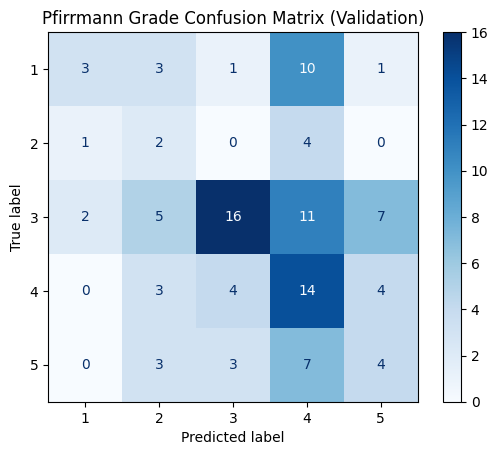

In [ ]:
cm = confusion_matrix(all_targets, all_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3, 4, 5])

disp.plot(cmap="Blues", values_format="d")
plt.title("Pfirrmann Grade Confusion Matrix (Validation)")
plt.show()

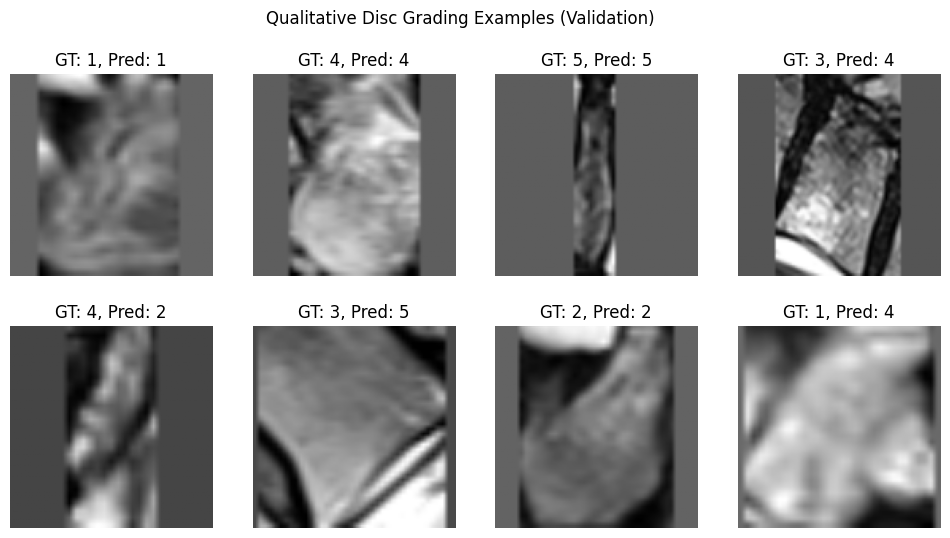

In [ ]:
model.eval()

examples = random.sample(range(len(val_ds)), 8)

plt.figure(figsize=(12, 6))

for i, idx in enumerate(examples):
    x, y = val_ds[idx]
    x = x.unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(x).argmax(dim=1).item()

    gt = y.item()

    plt.subplot(2, 4, i + 1)
    plt.imshow(x.cpu().squeeze(), cmap="gray")
    plt.title(f"GT: {gt+1}, Pred: {pred+1}")
    plt.axis("off")

plt.suptitle("Qualitative Disc Grading Examples (Validation)")
plt.show()